In [1]:
from fastai.basics           import *
from fastai.vision.all       import *
from fastai.medical.imaging  import *
from fastai.callback.tracker import *
from fastai.callback.all     import *
from fastai.data.transforms import IntToFloatTensor
from fastai.vision.augment import aug_transforms
from fastai.vision.core import Normalize
from fastai.torch_core import to_device
from fastai.medical.imaging import PILCTScan
from fastai.vision.all import *
from fastai.torch_core import to_device


import pandas as pd
import numpy as np
import os
from PIL import Image
import pandas as pd
import pickle
import scipy
import pydicom
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import scipy.stats
import copy
from IPython.display import display
import torch
import torch.nn as nn


In [2]:
np.set_printoptions(linewidth=120)
matplotlib.rcParams['image.cmap'] = 'bone'

In [3]:
# Paths
path = Path(r"F:\rsna")
path_trn = path/'stage_2_train'
path_tst = path/'stage_2_test'
path_jpg = r"F:\rsna\train_jpg"

In [4]:
# Load dataframes
df_comb = pd.read_csv(r"F:\meta\merged_csv_train_or_comb_train.csv").set_index('SOPInstanceUID')
df_tst  = pd.read_csv(r"F:\meta\stage2_test_metadata.csv").set_index('SOPInstanceUID')
df_samp = pd.read_csv(r"F:\rsna\wgt_sample.csv").set_index('SOPInstanceUID')
bins = pickle.load(open(path/"bins.pkl", "rb"))

In [5]:
# Set seed and split data
set_seed(42)
patients = df_comb.PatientID.unique()
pat_mask = np.random.random(len(patients)) < 0.8
pat_trn = patients[pat_mask]

In [6]:
def split_data(df):
    idx = L.range(df)
    mask = df.PatientID.isin(pat_trn)
    return idx[mask], idx[~mask]

splits = split_data(df_samp)

In [7]:
# Check the splits
df_trn = df_samp.iloc[splits[0]]
p1 = L.range(df_samp)[df_samp.PatientID == df_trn.PatientID[0]]
assert len(p1) == len(set(p1) & set(splits[0]))

In [8]:
def filename(o): return os.path.splitext(os.path.basename(o))[0]

fns = L(list(df_samp.fname)).map(filename)
fn = fns[0]

In [9]:
# Define a function to load images and handle errors
def open_image_with_error_handling(fn):
    try:
        img = Image.open(fn)
        img.verify()  # Verify that it is, indeed an image
        img = Image.open(fn)  # Re-open the image now that it's verified
        return img.convert('RGB')  # Ensure it's in RGB mode
    except Exception as e:
        print(f"Error opening image: {fn}")
        print(e)
        return None

In [10]:
# Modify fn2image function to use the new function
def fn2image(fn):
    file_path = os.path.join(path_jpg, fn + ".jpg")
    img = open_image_with_error_handling(file_path)
    if img is not None:
        img = PILImage.create(img)  # Convert to fastai's PILImage type
    return img

# Check if images are being loaded correctly
print(fn2image(fn))

PILImage mode=RGB size=256x256


In [11]:
# Define labels
htypes = ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
def fn2label(fn): return df_comb.loc[fn][htypes].values.astype(np.float32)

In [12]:
# Create Datasets and DataLoaders
tfms = [[fn2image], [fn2label, EncodedMultiCategorize(htypes)]]
dsrc = Datasets(fns, tfms, splits=splits)
nrm = Normalize.from_stats(*imagenet_stats)
aug = aug_transforms(p_lighting=0.)
batch_tfms = [IntToFloatTensor(), nrm, *aug]

In [13]:
def get_data(bs, sz):
    return dsrc.dataloaders(bs=bs, num_workers=nw, after_item=[ToTensor],
                            after_batch=batch_tfms + [AffineCoordTfm(size=sz)])

In [14]:
bs,nw = 128,4

(TensorImage(-0.1532), TensorImage(1.5896), torch.Size([128, 3, 96, 96]), 1011)

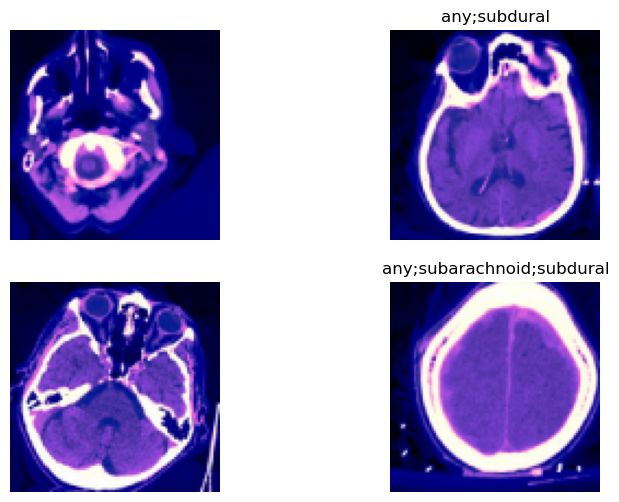

In [15]:
# Create DataLoaders
dbch = get_data(128, 96)

# Get one batch of data
xb, yb = to_cpu(dbch.one_batch())

# Show a batch of images
dbch.show_batch(max_n=4, figsize=(9, 6))

# Check statistics of the batch
xb.mean(), xb.std(), xb.shape, len(dbch.train)

In [16]:
def accuracy_any(inp, targ, thresh=0.5, sigmoid=True):
    inp, targ = flatten_check(inp[:,0], targ[:,0])
    if sigmoid: inp = inp.sigmoid()
    return ((inp > thresh) == targ.bool()).float().mean()

In [17]:
def get_loss(scale=1.0):
    loss_weights = torch.tensor([2.0, 1, 1, 1, 1, 1]).cuda() * scale
    return BaseLoss(nn.BCEWithLogitsLoss, pos_weight=loss_weights, floatify=True, flatten=False, is_2d=False)

In [18]:
loss_func = get_loss(0.14 * 2)
opt_func = partial(Adam, wd=0.01, eps=1e-3)
metrics = [accuracy_multi, accuracy_any]

In [19]:
def get_learner():
    dbch = get_data(128,128)
    learn = vision_learner(dbch, xresnet50, loss_func=loss_func, opt_func=opt_func, metrics=metrics)
    return learn.to_fp16()

In [20]:
learn = get_learner()

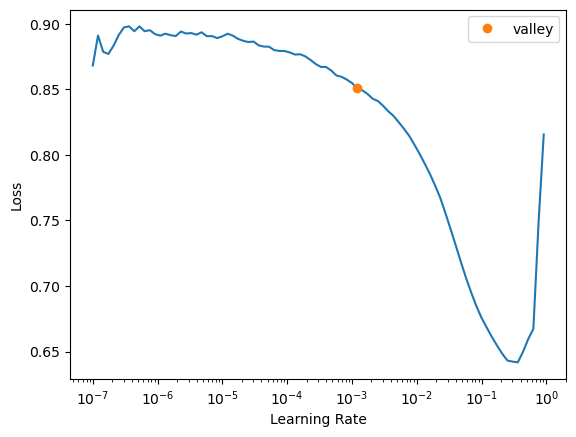

In [21]:
lrf = learn.lr_find()


In [22]:
def do_fit(bs,sz,epochs,lr, freeze=True):
    learn.dbunch = get_data(bs, sz)
    if freeze:
        if learn.opt is not None: learn.opt.clear_state()
        learn.freeze()
        learn.fit_one_cycle(1, slice(lr))
    learn.unfreeze()
    learn.fit_one_cycle(epochs, slice(lr))

In [23]:
do_fit(128, 96, 4, 1e-2)

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.183669,0.178312,0.821073,0.814002,10:23


epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.174860,0.170307,0.833844,0.811373,08:41
1,0.150862,0.170758,0.841935,0.795355,05:02
2,0.139161,0.136605,0.864993,0.854943,05:01
3,0.135469,0.132505,0.870162,0.864251,05:02


In [24]:
do_fit(128, 160, 3, 1e-3)


epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.133300,0.131983,0.870275,0.865024,04:57


epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.132968,0.131047,0.872481,0.869291,05:01
1,0.132730,0.130832,0.871089,0.864807,05:02
2,0.131480,0.129972,0.873986,0.870806,05:02


In [25]:
fns = L(list(df_comb.fname)).map(filename)
splits = split_data(df_comb)

In [26]:
def fix_pxrepr(dcm):
    if dcm.PixelRepresentation != 0 or dcm.RescaleIntercept<-100: return
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

In [27]:
def dcm_tfm(fn): 
    fn = (path_trn/fn).with_suffix('.dcm')
    try:
        x = fn.dcmread()
        fix_pxrepr(x)
    except Exception as e:
        print(fn,e)
        raise SkipItemException
    if x.Rows != 512 or x.Columns != 512: x.zoom_to((512,512))
    px = x.scaled_px
    return TensorImage(px.to_3chan(dicom_windows.brain,dicom_windows.subdural, bins=bins))

torch.Size([3, 512, 512])

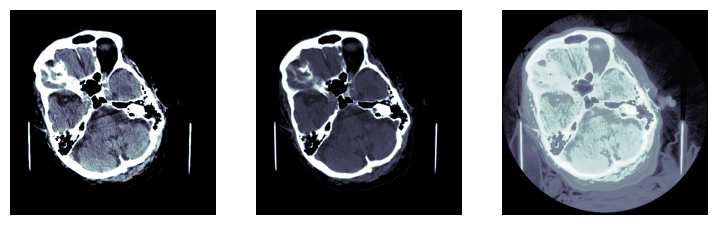

In [28]:
dcm = dcm_tfm(fns[0])
show_images(dcm)
dcm.shape

In [29]:
# Define transformations and dataset
tfms = [[dcm_tfm], [fn2label, EncodedMultiCategorize(htypes)]]
dsrc = Datasets(fns, tfms, splits=splits)
batch_tfms = [nrm, ToTensor(), *aug]

In [30]:
def get_data(bs, sz):
    dls = DataLoaders.from_dsets(
        dsrc.train, dsrc.valid, 
        bs=bs, 
        num_workers=nw, 
        after_batch=batch_tfms+[AffineCoordTfm(size=sz)]
    ).cuda()
    return dls

nw = 4  # Number of workers for data loading


torch.Size([64, 3, 256, 256])

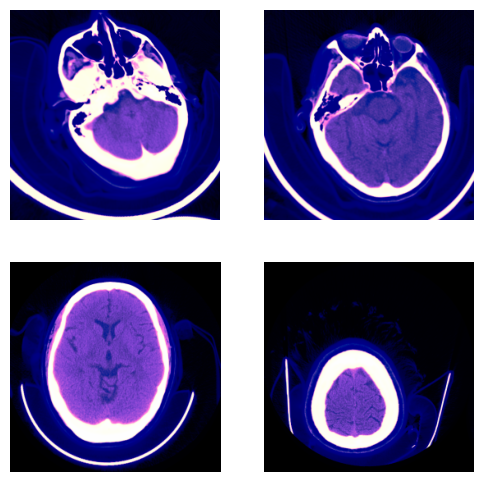

In [31]:
dbch = get_data(64, 256)
x, y = to_cpu(dbch.one_batch())
dbch.show_batch(max_n=4)
x.shape

In [32]:
learn.loss_func = get_loss(1.0)

In [33]:
def fit_tune(bs, sz, epochs, lr):
    dbch = get_data(bs, sz)
    learn.dbunch = dbch
    learn.opt.clear_state()
    learn.unfreeze()
    learn.fit_one_cycle(epochs, slice(lr))

In [34]:
fit_tune(64, 256, 2, 1e-3)

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.284826,0.281900,0.890035,0.875166,05:02
1,0.284110,0.274806,0.891251,0.871641,05:02


In [35]:
test_fns = [str(path_tst/f'{filename(o)}.dcm') for o in df_tst.fname.values]

In [36]:
# Create a DataLoader for the test set
tst_dl = dbch.test_dl(test_fns)

# Get a batch from the test DataLoader
x = tst_dl.one_batch()[0]
print(x.min(), x.max())

TensorImage(-2.1179, device='cuda:0') TensorImage(2.6400, device='cuda:0')


In [37]:
preds,targs = learn.get_preds(dl=tst_dl)
preds_clipped = preds.clamp(.0001, .999)


In [38]:
ids = []
labels = []

for idx,pred in zip(df_tst.index, preds_clipped):
    for i,label in enumerate(htypes):
        ids.append(f"{idx}_{label}")
        predicted_probability = '{0:1.10f}'.format(pred[i].item())
        labels.append(predicted_probability)

In [39]:
df_csv = pd.DataFrame({'ID': ids, 'Label': labels})
df_csv.to_csv(f'submission.csv', index=False)
df_csv.head()

,ID,Label
0,ID_000000e27_any,0.9990000129
1,ID_000000e27_epidural,0.0001000000
2,ID_000000e27_intraparenchymal,0.0001000000
3,ID_000000e27_intraventricular,0.0001000000
4,ID_000000e27_subarachnoid,0.0001000000


In [40]:
from IPython.display import FileLink, FileLinks
FileLink(path_dest/'submission.csv')

C:\Users\MSI\submission.csv